# Image Captioning: Data Preprocessing Pipeline

This notebook runs the preprocessing pipeline:
1. Load and clean caption data
2. Create train/validation/test splits
3. Build vocabulary
4. Save preprocessed data

In [1]:
# Setup and imports
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Add project root to path
project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

# Import project modules
from src.utils.manager import ConfigManager
from src.utils.constants import SEED
from src.utils.io import save_pickle, ensure_dir
from src.preprocessing.vocabulary import Vocabulary, preprocess_caption, analyze_vocab_coverage
from src.preprocessing.dataset import create_data_splits
from src.preprocessing.transforms import get_transforms, denormalize_image

# Set style
plt.style.use('default')

# Set random seed
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
# Initialize configuration manager
config_manager = ConfigManager()

# Get configurations
data_config = config_manager.get_data_params()
debug_mode = config_manager.debug

print(f"Debug mode: {debug_mode}")
if debug_mode:
    print(f"Max images in debug mode: {data_config['debug']['max_images']}")
    print(f"Output directory: {config_manager.paths['processed']}")

# Ensure output directories exist
ensure_dir(config_manager.paths['processed'])

Debug mode: False


## Load and Process Captions

In [3]:
# Load captions
captions_file = data_config['dataset']['captions_file']
images_dir = data_config['dataset']['images_dir']

print(f"Loading captions from: {captions_file}")
captions_df = pd.read_csv(captions_file)
print(f"Loaded {len(captions_df)} captions")

# If debug mode, limit dataset
if debug_mode:
    max_images = data_config['debug']['max_images']
    unique_images = captions_df['image'].unique()[:max_images]
    captions_df = captions_df[captions_df['image'].isin(unique_images)].reset_index(drop=True)
    print(f"\nDEBUG MODE: Limited to {len(unique_images)} images, {len(captions_df)} captions")

Loading captions from: c:\Users\dmxocean\Desktop\LAST\data\raw\flickr8k\captions.txt
Loaded 40455 captions


In [4]:
# Process captions
print("\nProcessing captions...")
captions_df['processed_caption'] = captions_df['caption'].apply(preprocess_caption)

# Show examples
print("\nSample processed captions:")
for i in range(min(3, len(captions_df))):
    print(f"Original: {captions_df.iloc[i]['caption']}")
    print(f"Processed: {captions_df.iloc[i]['processed_caption']}")
    print()


Processing captions...

Sample processed captions:
Original: A child in a pink dress is climbing up a set of stairs in an entry way .
Processed: a child in a pink dress is climbing up a set of stairs in an entry way .

Original: A girl going into a wooden building .
Processed: a girl going into a wooden building .

Original: A little girl climbing into a wooden playhouse .
Processed: a little girl climbing into a wooden playhouse .



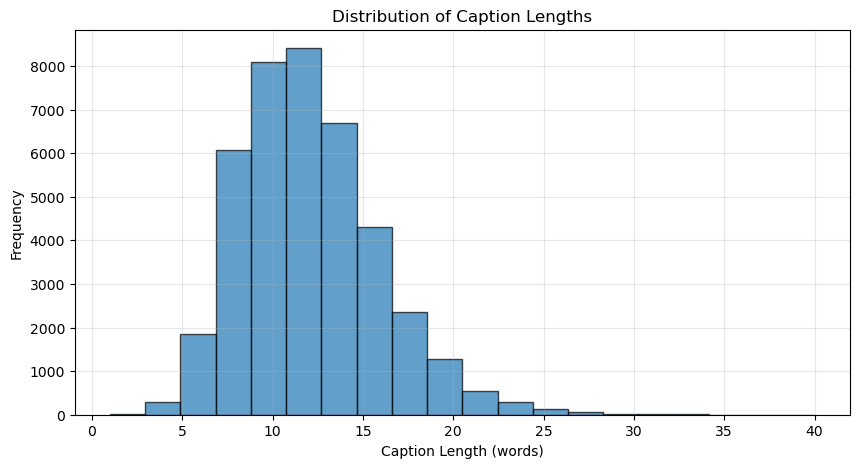

Caption length statistics:
count    40455.000000
mean        11.836584
std          3.918147
min          1.000000
25%          9.000000
50%         11.000000
75%         14.000000
max         40.000000
Name: caption_length, dtype: float64


In [ ]:
# Caption length analysis
captions_df['caption_length'] = captions_df['processed_caption'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
plt.hist(captions_df['caption_length'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Caption Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Lengths')
plt.grid(False)
plt.show()

print(f"Caption length statistics:")
print(captions_df['caption_length'].describe())

## Create Data Splits

In [6]:
# Create splits
train_ratio = data_config['preprocessing']['train_split']
val_ratio = data_config['preprocessing']['val_split']
test_ratio = data_config['preprocessing']['test_split']

print(f"Creating splits: train={train_ratio}, val={val_ratio}, test={test_ratio}")

train_df, val_df, test_df = create_data_splits(
    captions_df, 
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=test_ratio,
    random_state=SEED
)

print(f"\nSplit sizes:")
print(f"Train: {len(train_df)} captions, {len(train_df['image'].unique())} images")
print(f"Val: {len(val_df)} captions, {len(val_df['image'].unique())} images")
print(f"Test: {len(test_df)} captions, {len(test_df['image'].unique())} images")

Creating splits: train=0.7, val=0.15, test=0.15
Stratification verification:
  Short captions - Train: 34.8%, Val: 34.8%, Test: 34.8%
  Medium captions - Train: 32.9%, Val: 32.9%, Test: 32.9%
  Long captions - Train: 32.3%, Val: 32.3%, Test: 32.2%

Split sizes:
Train: 28315 captions, 5663 images
Val: 6070 captions, 1214 images
Test: 6070 captions, 1214 images


In [7]:
# Verify no overlap between splits
train_images = set(train_df['image'].unique())
val_images = set(val_df['image'].unique())
test_images = set(test_df['image'].unique())

print("Checking for overlaps between splits:")
print(f"Train-Val overlap: {len(train_images & val_images)} images")
print(f"Train-Test overlap: {len(train_images & test_images)} images")
print(f"Val-Test overlap: {len(val_images & test_images)} images")

assert len(train_images & val_images) == 0, "Train and validation sets overlap!"
assert len(train_images & test_images) == 0, "Train and test sets overlap!"
assert len(val_images & test_images) == 0, "Validation and test sets overlap!"
print("\nNo overlaps found!")

Checking for overlaps between splits:
Train-Val overlap: 0 images
Train-Test overlap: 0 images
Val-Test overlap: 0 images

No overlaps found!


## Build Vocabulary

In [8]:
# Build vocabulary from training set only
vocab_threshold = data_config['preprocessing']['vocab_threshold']
print(f"Building vocabulary with frequency threshold: {vocab_threshold}")

vocab = Vocabulary(freq_threshold=vocab_threshold)
vocab.build_vocabulary(train_df['processed_caption'].tolist())

# Show vocabulary statistics
print(f"\nVocabulary statistics:")
print(f"Total unique words seen: {len(vocab.word_frequencies)}")
print(f"Words in vocabulary: {len(vocab) - 4}")
print(f"Total vocabulary size (with special tokens): {len(vocab)}")

Building vocabulary with frequency threshold: 5
Building vocabulary from 28315 captions...


100%|██████████| 28315/28315 [00:00<00:00, 38336.82it/s]

Built vocabulary with 2510 tokens
Added 2506 words above frequency threshold 5

Vocabulary statistics:
Total unique words seen: 7278
Words in vocabulary: 2506
Total vocabulary size (with special tokens): 2510


In [9]:
# Analyze vocabulary coverage
print("\nVocabulary coverage analysis:")
print("\nTraining set:")
train_coverage, _ = analyze_vocab_coverage(train_df, vocab)

print("\nValidation set:")
val_coverage, _ = analyze_vocab_coverage(val_df, vocab)

print("\nTest set:")
test_coverage, _ = analyze_vocab_coverage(test_df, vocab)

print(f"\nSummary:")
print(f"Train coverage: {train_coverage:.2f}%")
print(f"Val coverage: {val_coverage:.2f}%")
print(f"Test coverage: {test_coverage:.2f}%")


Vocabulary coverage analysis:

Training set:
Vocabulary coverage: 97.64%
Total words: 335393
Unknown words: 7922

Top unknown words:
  lush: 4 occurrences
  newborn: 4 occurrences
  tags: 4 occurrences
  lunges: 4 occurrences
  modern: 4 occurrences
  taxi: 4 occurrences
  droplets: 4 occurrences
  bulldog: 4 occurrences
  inflated: 4 occurrences
  feather: 4 occurrences

Validation set:
Vocabulary coverage: 97.02%
Total words: 71792
Unknown words: 2138

Top unknown words:
  chicken: 8 occurrences
  floaties: 8 occurrences
  yawning: 7 occurrences
  priest: 7 occurrences
  feather: 7 occurrences
  eyebrows: 6 occurrences
  seagulls: 6 occurrences
  artificial: 5 occurrences
  twin: 5 occurrences
  mickey: 5 occurrences

Test set:
Vocabulary coverage: 96.98%
Total words: 71664
Unknown words: 2163

Top unknown words:
  hallway: 11 occurrences
  hydrant: 9 occurrences
  skeleton: 8 occurrences
  pigtails: 7 occurrences
  singer: 7 occurrences
  cards: 7 occurrences
  guitarist: 6 occurre

In [10]:
# Show most frequent words
print("\nMost frequent words in vocabulary:")
most_freq = vocab.get_most_frequent_words(20)
for i, (word, count) in enumerate(most_freq[:20], 1):
    print(f"{i:2d}. '{word}': {count} times")


Most frequent words in vocabulary:
 1. 'a': 44010 times
 2. '.': 25593 times
 3. 'in': 13324 times
 4. 'the': 12881 times
 5. 'on': 7478 times
 6. 'is': 6496 times
 7. 'and': 6236 times
 8. 'dog': 5559 times
 9. 'with': 5460 times
10. 'man': 5215 times
11. 'of': 4692 times
12. 'two': 4057 times
13. 'white': 2805 times
14. 'black': 2776 times
15. 'woman': 2489 times
16. 'boy': 2456 times
17. 'are': 2439 times
18. ',': 2355 times
19. 'girl': 2348 times
20. 'to': 2242 times


## Test Dataset Loading

In [11]:
# Test dataset creation
import torch
from src.preprocessing.dataset import FlickrDataset, FlickrCollate

# Get transforms
transform_train, transform_val = get_transforms(
    resize=data_config['image']['resize_size'],
    crop=data_config['image']['crop_size']
)

# Create small test dataset
test_dataset = FlickrDataset(
    data_df=train_df.iloc[:10],
    root_dir=images_dir,
    vocab=vocab,
    transform=transform_val
)

print(f"Test dataset size: {len(test_dataset)}")

Test dataset size: 10


Batch shapes:
Images: torch.Size([4, 3, 224, 224])
Captions: torch.Size([4, 21])
Lengths: [21, 19, 15, 11]

Image Captions:
Image 1: <SOS> a black dog and a white dog with brown spots are staring at each other in the street .
Image 2: <SOS> a black dog and a tri - colored dog playing with each other on the road .
Image 3: <SOS> two dogs of different breeds looking at each other on the road .
Image 4: <SOS> a black dog and a spotted dog are fighting


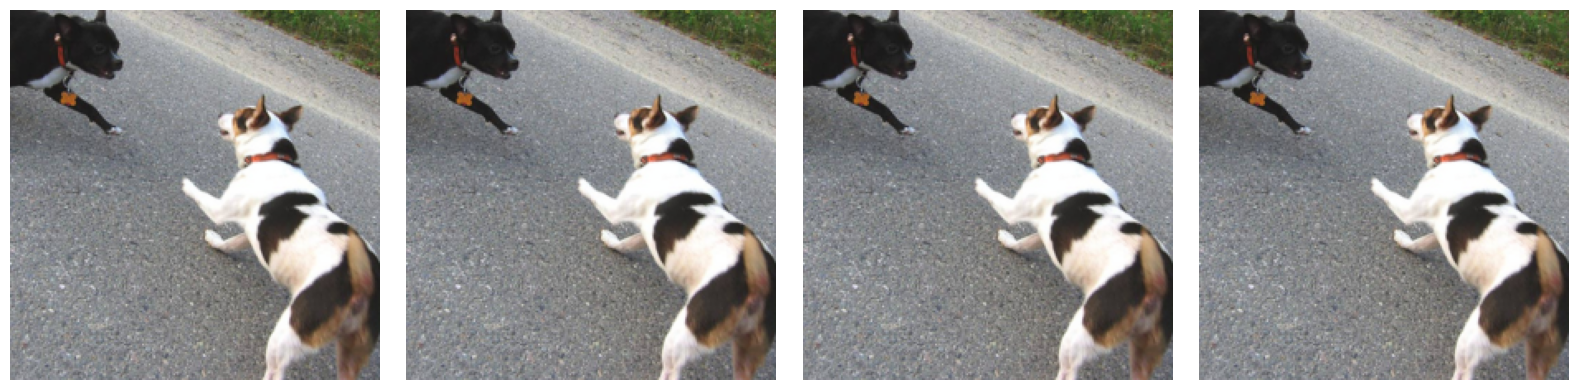

In [15]:
# Test data loading
from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=FlickrCollate(pad_idx=vocab.stoi["<PAD>"])
)

# Get one batch
images, captions, lengths = next(iter(test_loader))

print(f"Batch shapes:")
print(f"Images: {images.shape}")
print(f"Captions: {captions.shape}")
print(f"Lengths: {lengths}")

# Print captions before showing images
print("\nImage Captions:")
for i in range(4):
    caption_idx = captions[i].tolist()
    caption_words = []
    for idx in caption_idx:
        token = vocab.itos[idx]
        if token == "<EOS>":
            break
        if token not in ["<PAD>", "< SOS >"]:
            caption_words.append(token)
    
    print(f"Image {i+1}: {' '.join(caption_words)}")

# Display batch
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    # Denormalize and display image
    img = denormalize_image(images[i])
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Save Preprocessed Data

In [13]:
# Save vocabulary
vocab_path = config_manager.paths['vocab']
vocab.save(vocab_path)
print(f"Saved vocabulary to: {vocab_path}")

# Save data splits
splits_path = config_manager.paths['splits']
splits = {
    'train': train_df,
    'val': val_df,
    'test': test_df
}
save_pickle(splits, splits_path)
print(f"Saved data splits to: {splits_path}")

# Save summary
summary = {
    'dataset': data_config['dataset']['name'],
    'debug_mode': debug_mode,
    'vocab_size': len(vocab),
    'vocab_threshold': vocab_threshold,
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df),
    'train_images': len(train_df['image'].unique()),
    'val_images': len(val_df['image'].unique()),
    'test_images': len(test_df['image'].unique()),
    'train_coverage': train_coverage,
    'val_coverage': val_coverage,
    'test_coverage': test_coverage
}

from src.utils.io import save_json
summary_path = os.path.join(config_manager.paths['processed'], 'preprocessing_summary.json')
save_json(summary, summary_path)
print(f"\nSaved preprocessing summary to: {summary_path}")

Saved vocabulary to: c:\Users\dmxocean\Desktop\LAST\data\processed\flickr8k\vocab.pkl
Saved data splits to: c:\Users\dmxocean\Desktop\LAST\data\processed\flickr8k\splits.pkl

Saved preprocessing summary to: c:\Users\dmxocean\Desktop\LAST\data\processed\flickr8k\preprocessing_summary.json


In [14]:
# Print final summary
print("\nPREPROCESSING COMPLETE")
print()
print(f"Debug mode: {debug_mode}")
print(f"Output directory: {config_manager.paths['processed']}")
print(f"\nDataset:")
print(f"  Vocabulary size: {len(vocab)}")
print(f"  Training samples: {len(train_df)}")
print(f"  Validation samples: {len(val_df)}")
print(f"  Test samples: {len(test_df)}")
print(f"\nCoverage:")
print(f"  Train: {train_coverage:.2f}%")
print(f"  Val: {val_coverage:.2f}%")
print(f"  Test: {test_coverage:.2f}%")
print(f"\nFiles saved:")
print(f"  - {vocab_path}")
print(f"  - {splits_path}")
print(f"  - {summary_path}")


PREPROCESSING COMPLETE

Debug mode: False
Output directory: c:\Users\dmxocean\Desktop\LAST\data\processed\flickr8k

Dataset:
  Vocabulary size: 2510
  Training samples: 28315
  Validation samples: 6070
  Test samples: 6070

Coverage:
  Train: 97.64%
  Val: 97.02%
  Test: 96.98%

Files saved:
  - c:\Users\dmxocean\Desktop\LAST\data\processed\flickr8k\vocab.pkl
  - c:\Users\dmxocean\Desktop\LAST\data\processed\flickr8k\splits.pkl
  - c:\Users\dmxocean\Desktop\LAST\data\processed\flickr8k\preprocessing_summary.json
